In [1]:
from torchvision import datasets, transforms
from tqdm import tqdm
from torch import nn
import torch
from KAN import create_model
model=create_model()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, pin_memory=True, persistent_workers=True,num_workers=11)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)



In [5]:

model.train()
torch.cuda.empty_cache()

pbar = tqdm(range(0,10))

for epoch in pbar:
    torch.cuda.empty_cache()
    
    for i, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Loss: {loss.item():.2e}')

model.eval()
correct = 0
total = 0

with torch.no_grad():
    pbar = tqdm(test_loader)
    for x, y in pbar:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        _, predicted = torch.max(y_hat, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        pbar.set_description(f'Accuracy: {100 * correct / total:.2f}%')
    torch.cuda.empty_cache()


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 39.98%: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


In [ ]:
#torch.save(model.state_dict,"CIFAR10-39%.pt")

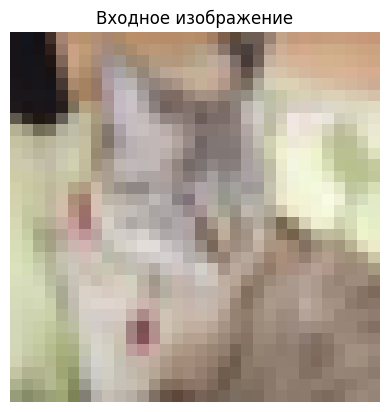

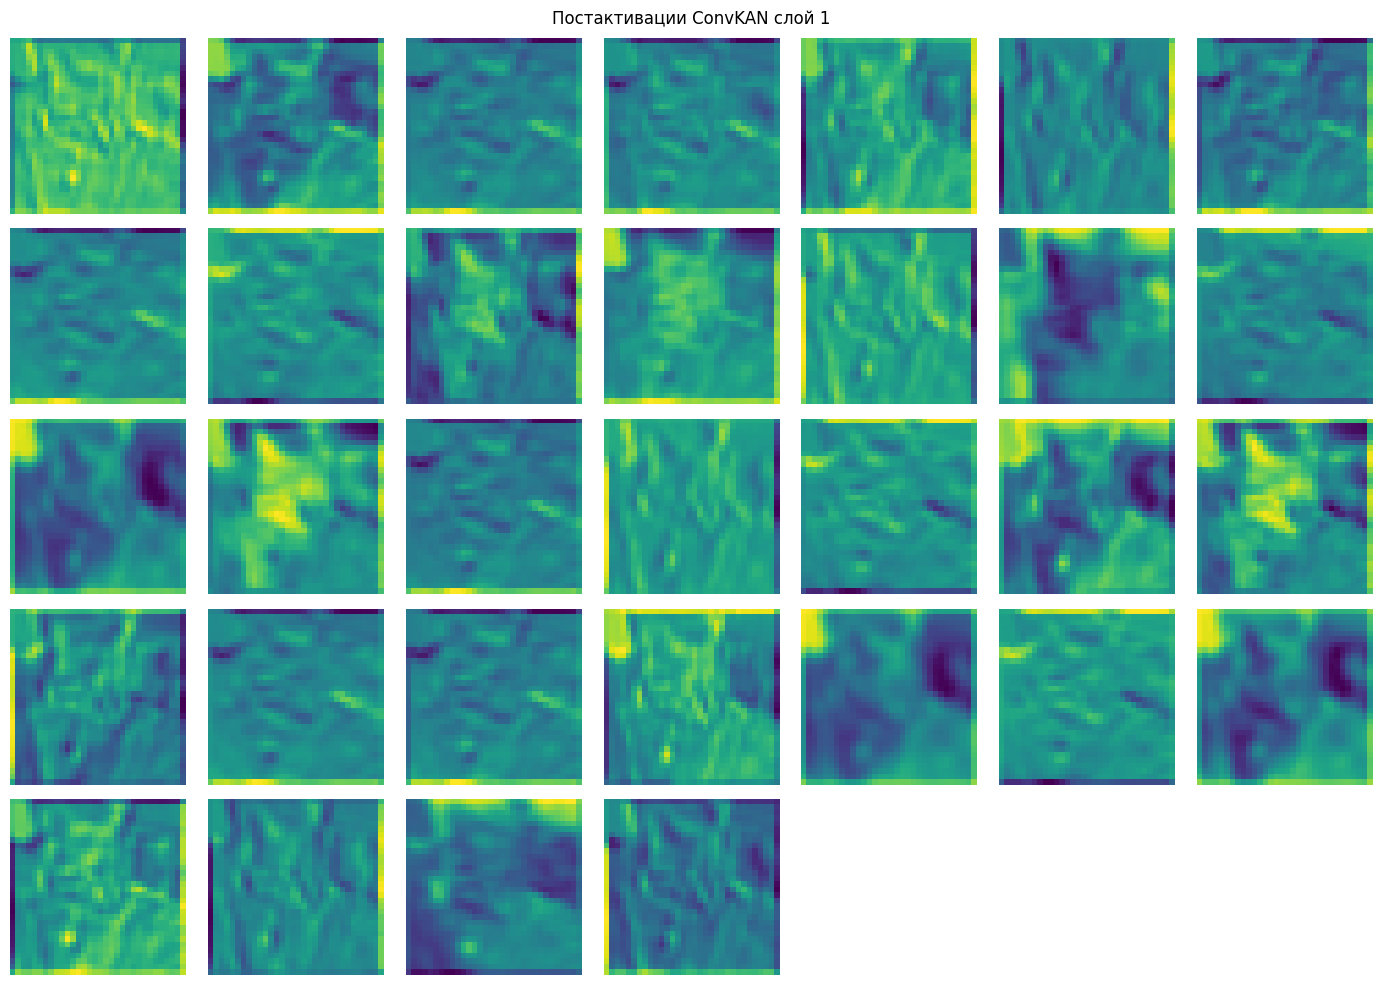

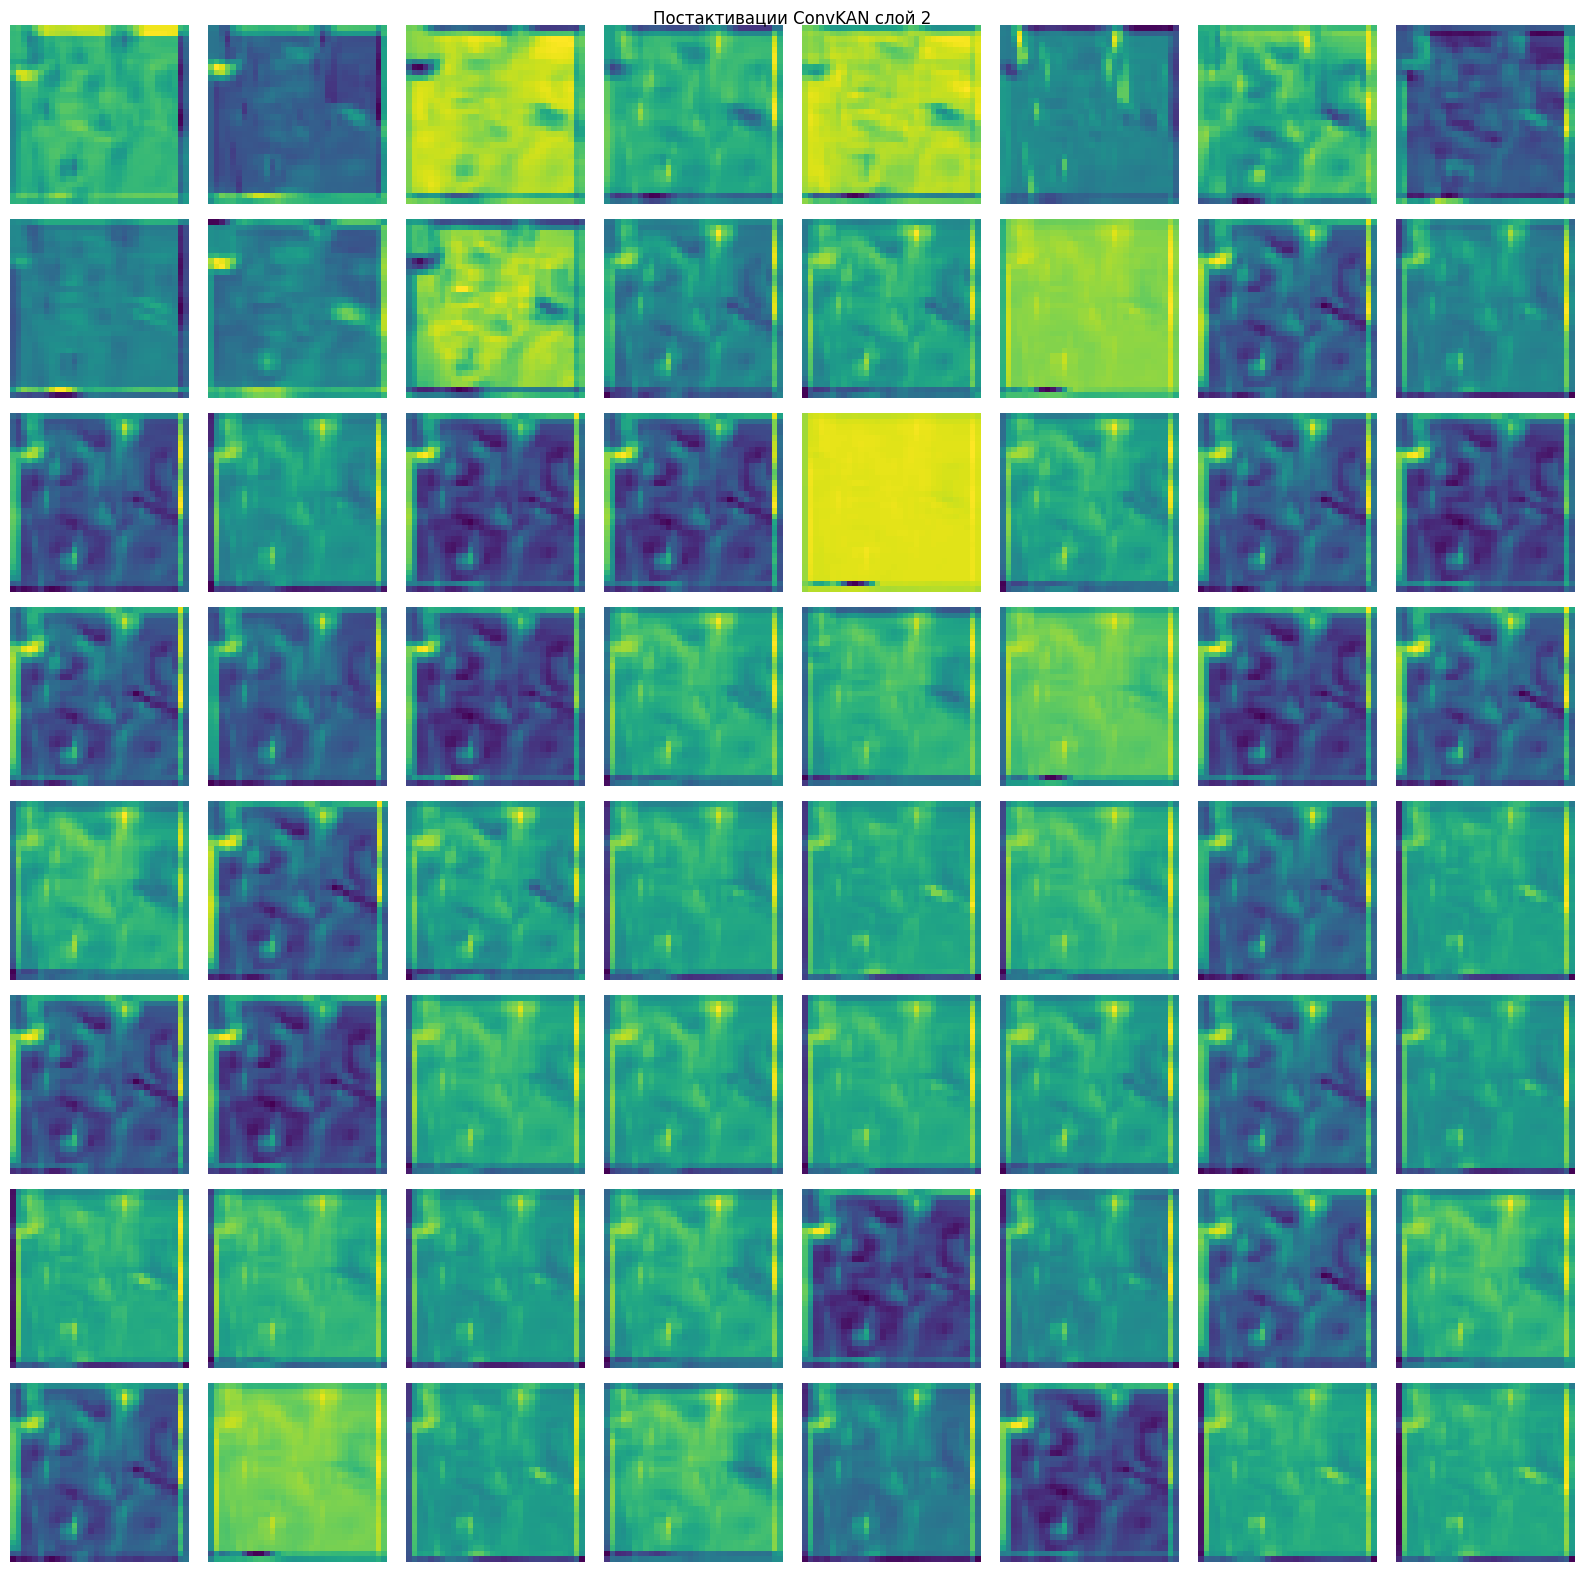

In [ ]:
import math
import numpy as np
import random
from convkan import ConvKAN, LayerNorm2D
import matplotlib.pyplot as plt
import torch

torch.cuda.empty_cache()

data_iter = iter(test_loader)
images, labels = next(data_iter)
idx = random.randint(0, images.size(0) - 1)
input_img = images[idx:idx+1].to('cuda:0')

post_activations = []

def save_activation(module, input, output):
    post_activations.append(output.detach().cpu())

hooks = []
for layer in model:
    if isinstance(layer, ConvKAN):
        hooks.append(layer.register_forward_hook(save_activation))

with torch.no_grad():
    _ = model(input_img)

for h in hooks:
    h.remove()

plt.figure()
plt.imshow(input_img.cpu()[0].permute(1, 2, 0))
plt.title("Входное изображение")
plt.axis("off")
plt.show()

def padded_grid(n_items: int):
    if n_items <= 0:
        return 0, 0
    rows = math.isqrt(n_items)
    cols = math.ceil(n_items / rows)
    if rows > cols:  
        rows, cols = cols, rows
    return rows, cols

for layer_idx, act in enumerate(post_activations, 1):
    act = act.squeeze(0)  
    if act.dim() == 4 and act.size(0) == 1:
        act = act.squeeze(0)           
    elif act.dim() == 4:
        act = act[0]

    num_channels = act.shape[0]
    rows, cols = padded_grid(num_channels)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    fig.suptitle(f"Постактивации ConvKAN слой {layer_idx}")
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = np.array([[ax] for ax in axes])

    flat_axes = axes.ravel()
    for ch in range(num_channels):
        ax = flat_axes[ch]
        ax.imshow(act[ch], cmap="viridis")
        ax.axis("off")

    for k in range(num_channels, rows*cols):
        flat_axes[k].axis("off")

    plt.tight_layout()
    plt.show()



In [12]:
for layer in model:
    if isinstance(layer, ConvKAN) and hasattr(layer, "kan_layer"):
        print(f"grid: {len(layer.kan_layer.grid[0])}")
        print(f"grid[0]: {len(layer.kan_layer.grid[0][0])}")
        print(f"weights[0]:{len(layer.kan_layer.scaled_spline_weight[0][0])}")
        print(f"weights[][]: {len(layer.kan_layer.scaled_spline_weight[0][0][0])}")

grid: 27
grid[0]: 12
weights[0]:27
weights[][]: 8
grid: 288
grid[0]: 8
weights[0]:288
weights[][]: 6


/tmp/ipykernel_79036/3776061048.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid = np.array(layer.kan_layer.grid.cpu())


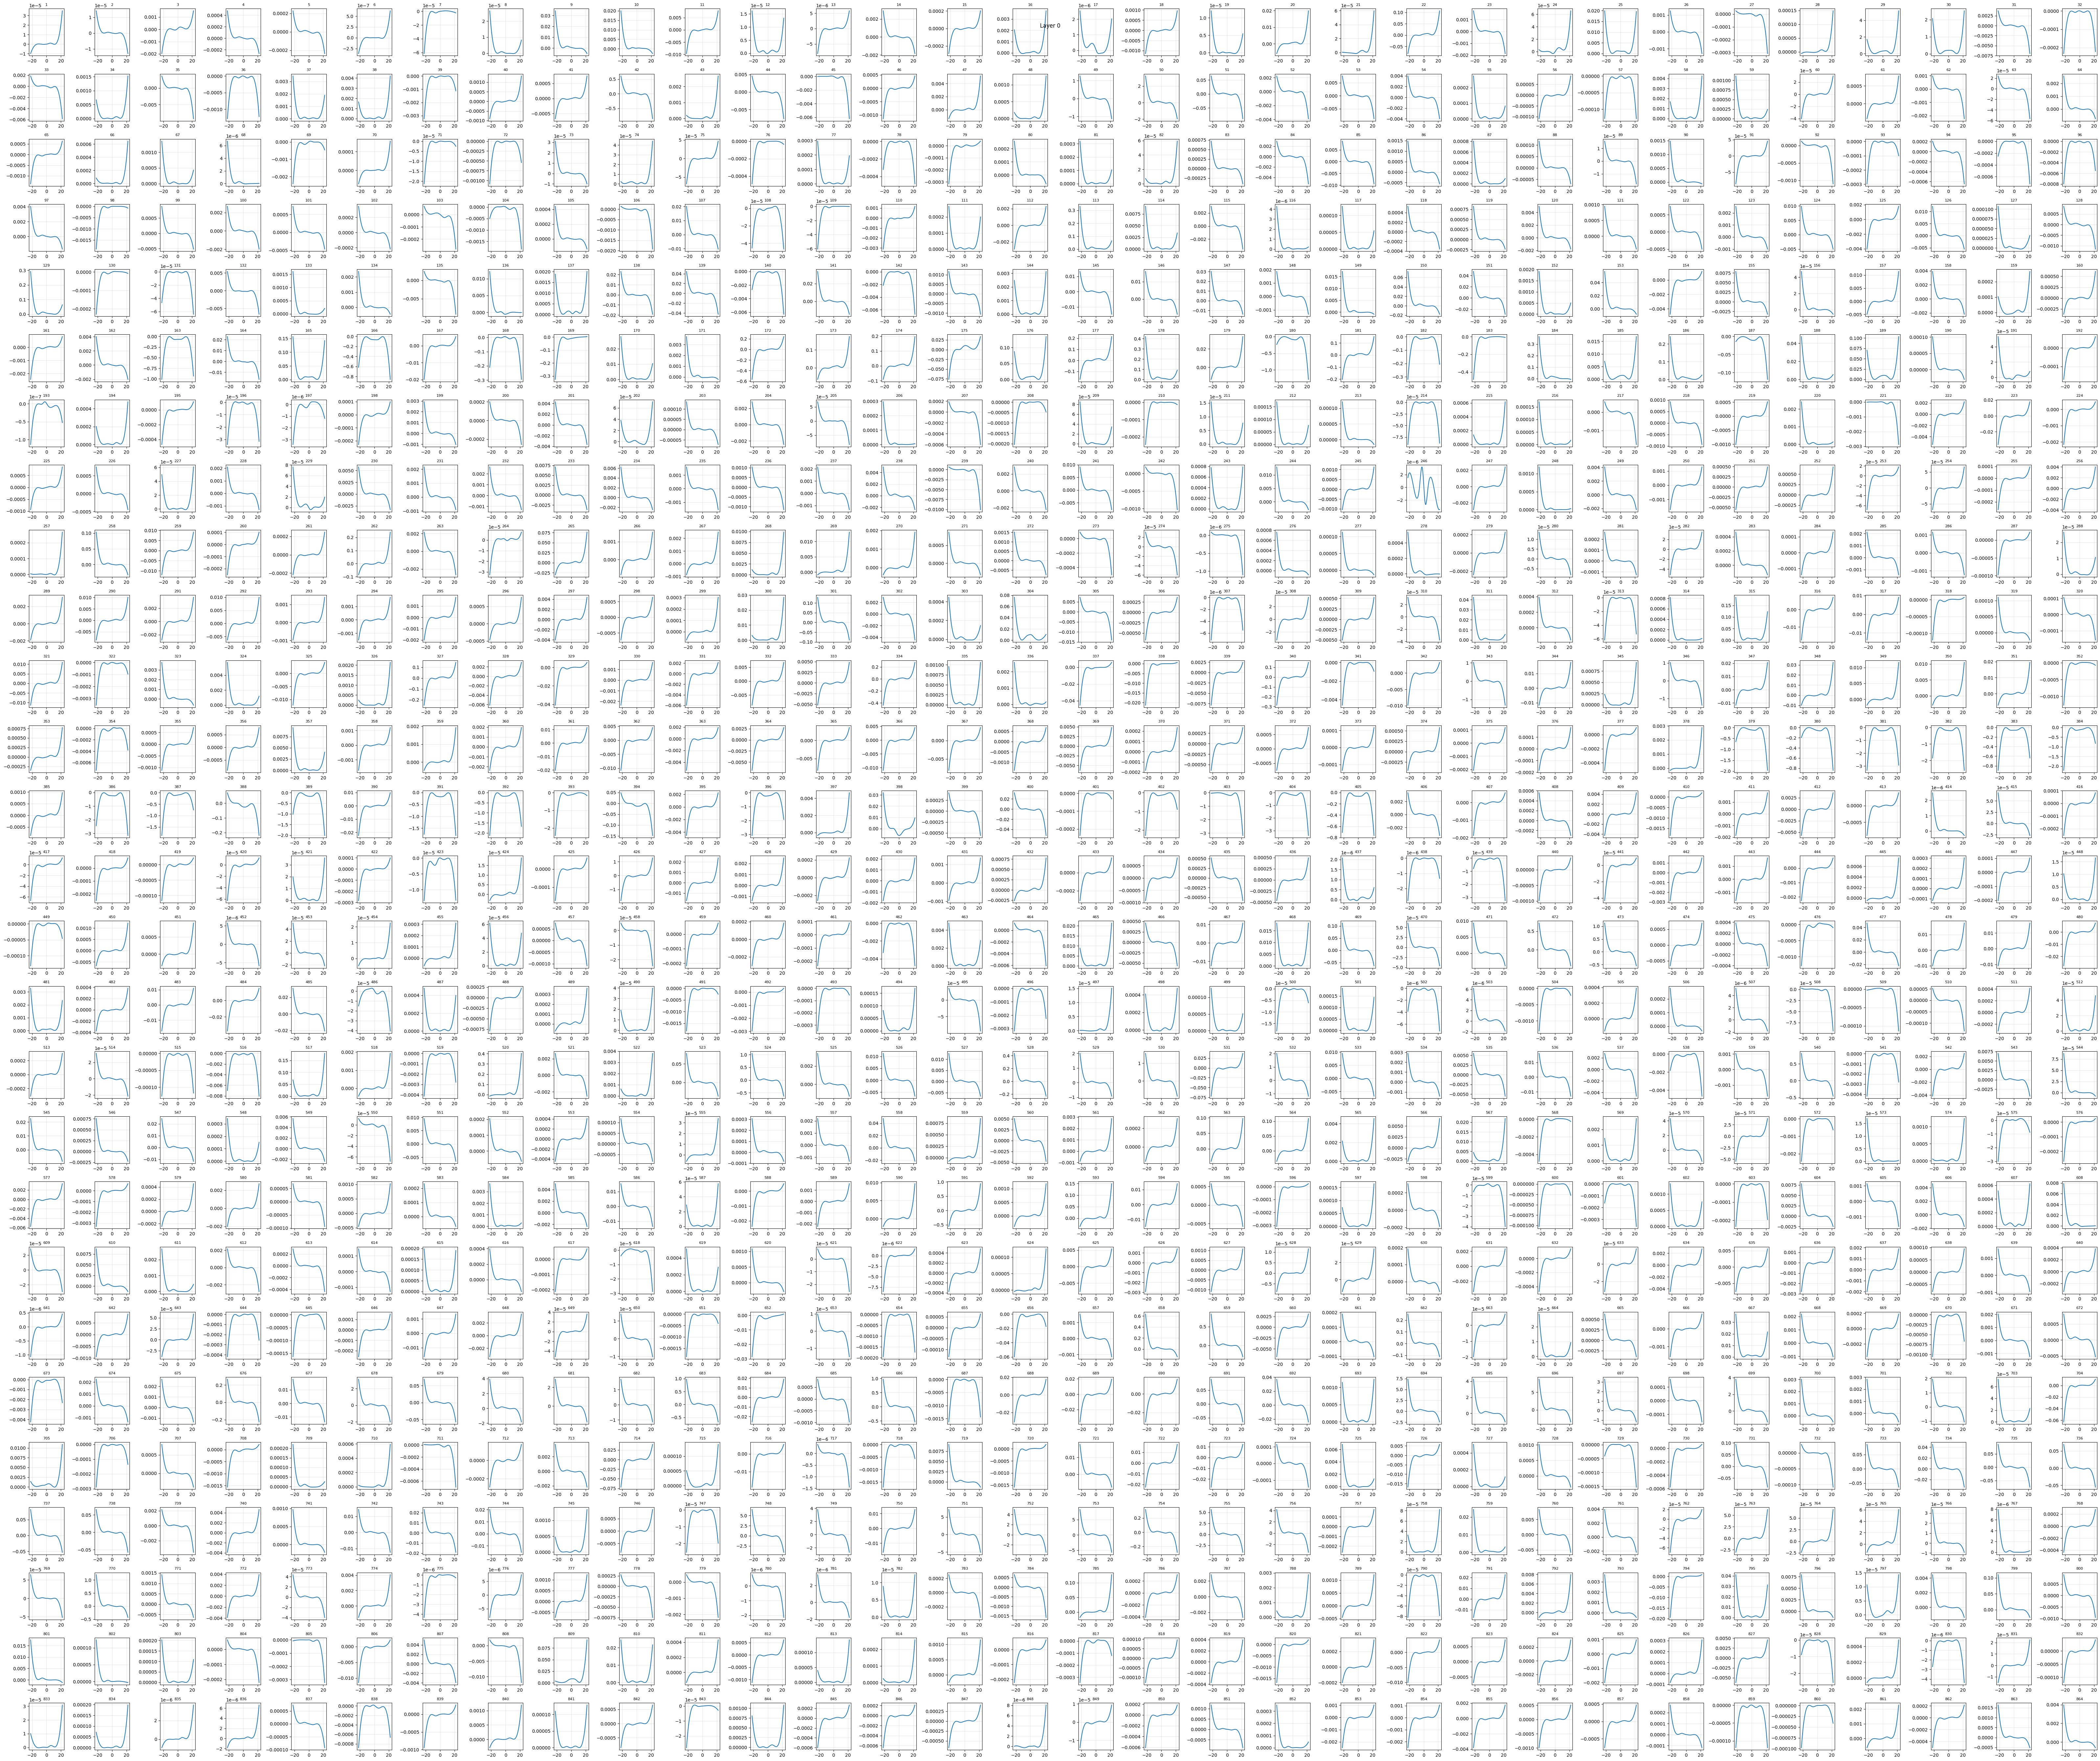

: 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline
import math

def plot_spline_layer(grid, weights,k, title):
    if grid.ndim > 1:
        grid = grid[0][0]

    n_splines = weights.shape[0]
    rows = math.isqrt(n_splines)
    while rows > 1 and n_splines % rows != 0:
        rows -= 1
    cols = n_splines // rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    fig.suptitle(title)
    m=0
    for idx in range(n_splines):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        x = np.linspace(grid[0], grid[-1], 200)
        spline=BSpline(grid,weights[m],k=k)
        y=spline(x)
        
        ax.plot(x, y)
        ax.set_title(str(idx+1), fontsize=8)
        ax.grid(True, alpha=0.3)
        m+=1
        

    for idx in range(n_splines, rows*cols):
        r, c = divmod(idx, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

for i, layer in enumerate(model):
    if isinstance(layer, ConvKAN) and hasattr(layer, "kan_layer"):
        grid = np.array(layer.kan_layer.grid.cpu())
        weights = np.array(layer.kan_layer.scaled_spline_weight.detach().cpu().numpy())
        k=layer.kan_layer.spline_order
        weights = weights.reshape(-1, weights.shape[-1])
        plot_spline_layer(grid, weights,k, f"Layer {i}")
